<h1 style="font-size: 90%; text-align: center;">ALEX-NET Architecture </h1>



<h3 style="text-align:center;">CIFAR-10 Class Overview</h3>

<table border="1" style="border-collapse: collapse; text-align: center; width:70%; margin:auto; font-size:14px;">
  <tr style="background-color:#f2f2f2;">
    <th>Index</th>
    <th>Class</th>
    <th>Description</th>
  </tr>
  <tr><td>0</td><td>airplane</td><td>Aircraft such as airplanes or jets</td></tr>
  <tr><td>1</td><td>automobile</td><td>Cars and small vehicles</td></tr>
  <tr><td>2</td><td>bird</td><td>Various bird species</td></tr>
  <tr><td>3</td><td>cat</td><td>Domestic cats and kittens</td></tr>
  <tr><td>4</td><td>deer</td><td>Deer and similar animals</td></tr>
  <tr><td>5</td><td>dog</td><td>Domestic dogs of different breeds</td></tr>
  <tr><td>6</td><td>frog</td><td>Frogs or toads</td></tr>
  <tr><td>7</td><td>horse</td><td>Horses and ponies</td></tr>
  <tr><td>8</td><td>ship</td><td>Boats, ships, and vessels</td></tr>
  <tr><td>9</td><td>truck</td><td>Large transport trucks</td></tr>
</table>


In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [ ]:
import torch

# Check device (GPU / CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")


if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f" CUDA available: True")
    print(f" Using GPU device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print(" CUDA not available. Using CPU instead.")

print(f"Using device for computation: {device}")


Running on device: cuda
 CUDA available: True
 Using GPU device: Tesla T4
Using device for computation: cuda


<h1 style="font-size: 90%; text-align: center;">DATA INGEST AND OPT </h1>

In [ ]:
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset  = CIFAR10(root='./data', train=False, transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

<h1 style="font-size: 90%; text-align: center;">Initializing the Alex net arch</h1>

In [ ]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Feature extractor for CIFAR-10 (32x32 input)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier adjusted for 32x32 input (→ output 256×4×4)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



 <h1 style="font-size: 90%; text-align: center;"> DATA PREPARATION AND PREPROCESSING (CIFAR-10)</h1>

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # force CIFAR-size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



 <h1 style="font-size: 90%; text-align: center;"> INITIALIZE MODEL, LOSS FUNCTION, AND OPTIMIZER</h1>

In [ ]:
# Model, Loss, Optimizer Setup
model = AlexNet(num_classes=10).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer (SGD with momentum & weight decay)
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)

#  Print summary info
print("Model initialized on:", device)
print("Number of trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

x = torch.randn(1, 3, 32, 32).to(device)
out = model(x)
print(out.shape)  #  should print: torch.Size([1, 10])



Model initialized on: cuda
Number of trainable parameters: 35855178
torch.Size([1, 10])



 <h1 style="font-size: 90%; text-align: center;"> TRAINING AND VALIDATION</h1>

In [ ]:
from tqdm.notebook import tqdm
import torch
import gc


num_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    #  Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = val_loss / len(test_loader)
    test_acc = 100.0 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f" Train Loss: {train_loss:.4f} |  Train Acc: {train_acc:.2f}%")
    print(f" Val Loss:   {test_loss:.4f} |  Val Acc:   {test_acc:.2f}%")

    #  Free unused memory (important for Colab)
    torch.cuda.empty_cache()
    gc.collect()


 Epoch 1/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 1.9067 |  Train Acc: 27.93%
 Val Loss:   1.4794 |  Val Acc:   44.26%

 Epoch 2/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 1.3412 |  Train Acc: 50.61%
 Val Loss:   1.1303 |  Val Acc:   59.14%

 Epoch 3/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 1.0339 |  Train Acc: 62.94%
 Val Loss:   0.9120 |  Val Acc:   68.11%

 Epoch 4/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.8459 |  Train Acc: 70.22%
 Val Loss:   0.8026 |  Val Acc:   72.14%

 Epoch 5/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.7233 |  Train Acc: 74.54%
 Val Loss:   0.7206 |  Val Acc:   75.70%

 Epoch 6/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.6313 |  Train Acc: 77.82%
 Val Loss:   0.6573 |  Val Acc:   77.25%

 Epoch 7/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.5467 |  Train Acc: 80.95%
 Val Loss:   0.6249 |  Val Acc:   78.73%

 Epoch 8/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.4779 |  Train Acc: 83.38%
 Val Loss:   0.5902 |  Val Acc:   80.25%

 Epoch 9/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.4110 |  Train Acc: 85.77%
 Val Loss:   0.5733 |  Val Acc:   81.06%

 Epoch 10/10


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

 Train Loss: 0.3591 |  Train Acc: 87.32%
 Val Loss:   0.5658 |  Val Acc:   81.34%



 <h1 style="font-size: 90%; text-align: center;">  PLOT TRAINING VS VALIDATION METRICS</h1>

Epoch 10/10 [Validation]:   0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 0.3591 |  Train Acc: 87.32%
 Val Loss:   0.5658 |  Val Acc:   81.34%


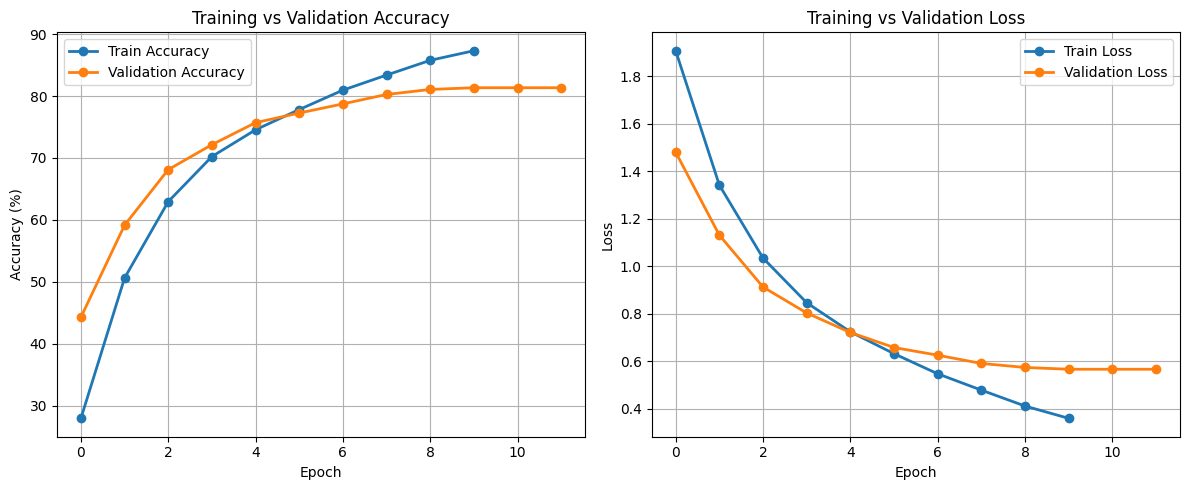

In [ ]:

# Validation Block (per epoch)

model.eval()
val_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = val_loss / len(test_loader)
test_acc = 100 * correct / total
test_losses.append(test_loss)
test_accuracies.append(test_acc)

print(f"Train Loss: {train_loss:.4f} |  Train Acc: {train_acc:.2f}%")
print(f" Val Loss:   {test_loss:.4f} |  Val Acc:   {test_acc:.2f}%")


# Training vs Validation Metrics Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o', linewidth=2)
plt.plot(test_accuracies, label='Validation Accuracy', marker='o', linewidth=2)
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o', linewidth=2)
plt.plot(test_losses, label='Validation Loss', marker='o', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



 <h1 style="font-size: 90%; text-align: center;">  ACCURACY GRAPH</h1>

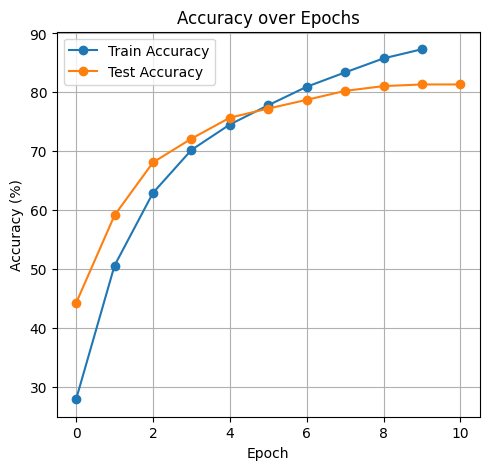

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)


 <h1 style="font-size: 90%; text-align: center;">  LOSS GRAPH</h1>

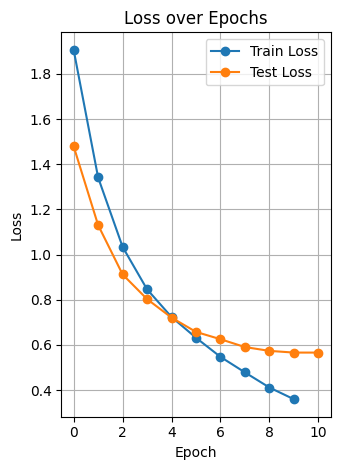

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


 <h1 style="font-size: 90%; text-align: center;">  MODEL EVAL</h1>

In [ ]:
final_accuracy = test_accuracies[-1]
print(f"\n Final Test Accuracy: {final_accuracy:.2f}%")


 Final Test Accuracy: 81.34%



 <h1 style="font-size: 90%; text-align: center;"> QUICK TEST </h1>

Found image: /content/cat1.png


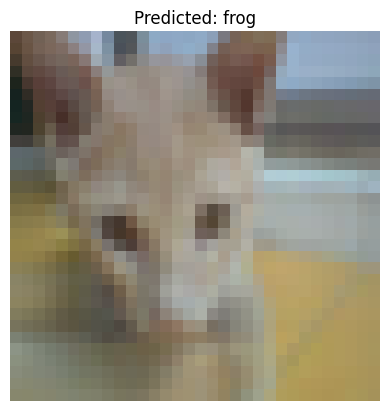

In [108]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

# CIFAR-10 class labels
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Find uploaded image (in /content)
image_files = [f for f in os.listdir('/content') if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if len(image_files) == 0:
    raise FileNotFoundError("No image found in /content. Please upload one (e.g. car.jpg, cat.png).")

img_path = os.path.join('/content', image_files[0])
print(f"Found image: {img_path}")

# Load trained model
model = AlexNet(num_classes=10)
model.load_state_dict(torch.load("/content/alexnet_cifar10.pth", map_location='cpu'))
model.eval()

# Image preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # CIFAR-10 image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Predict
img = Image.open(img_path).convert("RGB")
img_t = transform(img).unsqueeze(0)

with torch.no_grad():
    outputs = model(img_t)
    _, pred = outputs.max(1)
    predicted_label = classes[pred.item()]

# Display image and result
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


In [ ]:
torch.save(model.state_dict(), "/content/alexnet_cifar10.pth")
print(" Model saved at /content/alexnet_cifar10.pth")

!ls /content


 Model saved at /content/alexnet_cifar10.pth
alexnet_cifar10.pth  data  sample_data	test_image.jpg
